# **Multi Task Learning**

In this notebook we will learn how to use Multi-Task Learning to train a model to simultaneously segment and predict depth on a single image

### References:
- https://arxiv.org/pdf/1705.07115.pdf
- https://arxiv.org/pdf/1706.05587.pdf
- https://cs.nyu.edu/~silberman/papers/indoor_seg_support.pdf

In [7]:
import os

import numpy as np
import h5py
import cv2

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

import matplotlib as mpl
import matplotlib.pyplot as plt

# local imports
from nyu_dataset import NyuDataset
from utils import *

%matplotlib inline

## CONFIGs

In [8]:
BATCH_SIZE = 2 # 16
EPOCHS = 100
LR = 1e-4

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Get Train/Valid/Test split

Since we are accessing the .mat file as an h5 object, we will make 2 datasets one for training and the other for valid/test/inference. If we set the random seed, this will allow us to get the appropriate splits.

In [9]:
root = r"C:\Users\itber\Documents\datasets\nyu_depth_seg\nyu_depth_v2_labeled.mat"

In [10]:
train_augmentations = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomResizedCrop((240, 320)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50),
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(1, 1)),
    transforms.ElasticTransform(alpha=25.0, sigma=5.0),
])

test_augmentations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((240, 320)),
])

train_nyu_dataset = NyuDataset(root, augmentations=train_augmentations, normalize=True, depth_norm=10)
test_nyu_dataset = NyuDataset(root, augmentations=test_augmentations, normalize=True, depth_norm=10)

In [11]:
from torch.utils.data import random_split

seed = 42

# get train split
num_train = round(0.7*len(train_nyu_dataset))
num_remain = round(0.3*len(train_nyu_dataset))
(train_dataset, _) = random_split(train_nyu_dataset,
                                              [num_train, num_remain],
                                              generator=torch.Generator().manual_seed(seed))

""" 
Sketchy hack to get valid/test datasets
"""

(_, remain_dataset) = random_split(test_nyu_dataset,
                                              [num_train, num_remain],
                                              generator=torch.Generator().manual_seed(seed))

# get valid and test split
num_valid = round(0.8*len(remain_dataset))
num_test = round(0.2*len(remain_dataset))
(valid_dataset, test_dataset) = random_split(remain_dataset,
                                             [num_valid, num_test],
                                              generator=torch.Generator().manual_seed(seed))

In [12]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True) 
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

In [13]:
image, (depth, label) = next(iter(train_dataloader))

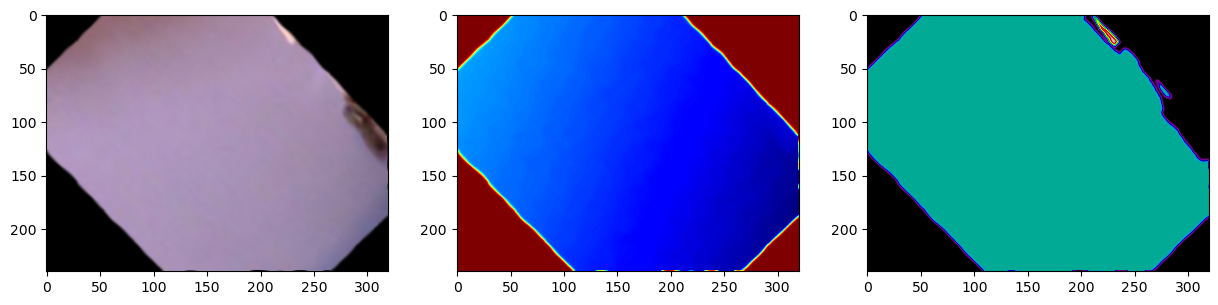

In [32]:
# get format for display
idx = 1
image_np, depth_np, label_np = convert_to_numpy(image[idx], depth[idx], label[idx])

_, ax = plt.subplots(1, 3, figsize=(15, 8))
ax[0].imshow(image_np)
ax[1].imshow(depth_np, cmap='jet_r')
ax[2].imshow(label_np, cmap='nipy_spectral');

## Get the model

Look at this [resource](https://discuss.pytorch.org/t/how-can-i-replace-the-forward-method-of-a-predefined-torchvision-model-with-my-customized-forward-function/54224/7) to learn how to make a custom forward function for the backbone

In [98]:
from torchvision.models import resnet18, resnet34, resnet50, mobilenet_v3_small
from torchvision.models.segmentation import deeplabv3_resnet50


# get backbone and download pretrained weights
backbone = mobilenet_v3_small(weights='IMAGENET1K_V1',
                    # replace_stride_with_dilation=[False, True, True] # add atriuos convolutions
                    ) 
deeplabv3 = deeplabv3_resnet50(weights='COCO_WITH_VOC_LABELS_V1', weights_backbone='IMAGENET1K_V1')

Get multi task blocks

In [52]:
from copy import deepcopy

backbone = deeplabv3.backbone
seg_head = deepcopy(deeplabv3.classifier)
depth_head = deepcopy(deeplabv3.classifier)

In [54]:
num_seg_classes = len(train_nyu_dataset.names[0])
num_seg_classes

894

Add correct outputs

In [55]:
# seg_head[4] = torch.nn.Conv2d(256, num_seg_classes, kernel_size=(1, 1), stride=(1, 1))
# depth_head[4] = torch.nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))

In [56]:
30*16, 40*16

(480, 640)

In [71]:
""" from torch vision DeepLabV3 Code
    https://github.com/pytorch/vision/blob/main/torchvision/models/segmentation/deeplabv3.py
"""
from typing import List

class DeepLabHead(nn.Sequential):
    def __init__(self, in_channels: int, num_classes: int) -> None:
        super().__init__(
            ASPP(in_channels, [12, 24, 36]),
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, num_classes, 1),
        )


class ASPPConv(nn.Sequential):
    def __init__(self, in_channels: int, out_channels: int, dilation: int) -> None:
        modules = [
            nn.Conv2d(in_channels, out_channels, 3, padding=dilation, dilation=dilation, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        ]
        super().__init__(*modules)


class ASPPPooling(nn.Sequential):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        size = x.shape[-2:]
        for mod in self:
            x = mod(x)
        return F.interpolate(x, size=size, mode="bilinear", align_corners=False)


class ASPP(nn.Module):
    def __init__(self, in_channels: int, atrous_rates: List[int], out_channels: int = 256) -> None:
        super().__init__()
        modules = []
        modules.append(
            nn.Sequential(nn.Conv2d(in_channels, out_channels, 1, bias=False), nn.BatchNorm2d(out_channels), nn.ReLU())
        )

        rates = tuple(atrous_rates)
        for rate in rates:
            modules.append(ASPPConv(in_channels, out_channels, rate))

        modules.append(ASPPPooling(in_channels, out_channels))

        self.convs = nn.ModuleList(modules)

        self.project = nn.Sequential(
            nn.Conv2d(len(self.convs) * out_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.5),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        _res = []
        for conv in self.convs:
            _res.append(conv(x))
        res = torch.cat(_res, dim=1)
        return self.project(res)


In [72]:
# class MultiTaskModel(nn.Module):
#     def __init__(self, backbone, seg_head, depth_head):
#         super().__init__()
#         # aggregate Layers backbone layers so that we can use our own forward function
#         self.backbone = nn.Sequential(*nn.ModuleList(backbone.children()))
#         self.backbone = nn.Sequential(*nn.ModuleList(backbone.children())[:-2]) # resnet
#         self.seg_head = nn.Sequential(*nn.ModuleList(seg_head.children()))
#         self.depth_head = nn.Sequential(*nn.ModuleList(depth_head.children()))
        
#     def forward(self, x):
#         x = self.backbone(x)
#         print(x.shape)
#         seg_pred = self.seg_head(x)
#         # depth_pred = self.depth_head(x)

#         return  seg_pred # (seg_pred, depth_pred)


class MultiTaskModel(nn.Module):
    def __init__(self, backbone, seg_head, depth_head):
        super().__init__()
        # aggregate Layers backbone layers so that we can use our own forward function
        # self.backbone = nn.Sequential(*nn.ModuleList(backbone.children()))
        self.backbone = backbone
        self.seg_head = seg_head
        self.depth_head = depth_head
        
    def forward(self, x):
        input_shape = x.shape[-2:]

        features = self.backbone(x)

        seg_pred = self.seg_head(features)
        depth_pred = self.depth_head(features)

        seg_pred = F.interpolate(seg_pred, size=input_shape, mode="bilinear", align_corners=False)
        depth_pred = F.interpolate(depth_pred, size=input_shape, mode="bilinear", align_corners=False)

        return  (seg_pred, depth_pred)

In [97]:
backbone = nn.Sequential(*nn.ModuleList(backbone.children())[:-2]) # remove last 2 layers of resnet
seg_head = DeepLabHead(2048, 21)
depth_head = DeepLabHead(2048, 27)

weights_path = r"C:\Users\itber\.cache\torch\hub\checkpoints\deeplabv3_resnet50_coco-cd0a2569.pth"
weights = torch.load(weights_path)
seg_head.load_state_dict(weights) # .get_state_dict(progress=progress, check_hash=True))

RuntimeError: Error(s) in loading state_dict for DeepLabHead:
	Missing key(s) in state_dict: "0.convs.0.0.weight", "0.convs.0.1.weight", "0.convs.0.1.bias", "0.convs.0.1.running_mean", "0.convs.0.1.running_var", "0.convs.1.0.weight", "0.convs.1.1.weight", "0.convs.1.1.bias", "0.convs.1.1.running_mean", "0.convs.1.1.running_var", "0.convs.2.0.weight", "0.convs.2.1.weight", "0.convs.2.1.bias", "0.convs.2.1.running_mean", "0.convs.2.1.running_var", "0.convs.3.0.weight", "0.convs.3.1.weight", "0.convs.3.1.bias", "0.convs.3.1.running_mean", "0.convs.3.1.running_var", "0.convs.4.1.weight", "0.convs.4.2.weight", "0.convs.4.2.bias", "0.convs.4.2.running_mean", "0.convs.4.2.running_var", "0.project.0.weight", "0.project.1.weight", "0.project.1.bias", "0.project.1.running_mean", "0.project.1.running_var", "1.weight", "2.weight", "2.bias", "2.running_mean", "2.running_var", "4.weight", "4.bias". 
	Unexpected key(s) in state_dict: "backbone.conv1.weight", "backbone.bn1.weight", "backbone.bn1.bias", "backbone.bn1.running_mean", "backbone.bn1.running_var", "backbone.bn1.num_batches_tracked", "backbone.layer1.0.conv1.weight", "backbone.layer1.0.bn1.weight", "backbone.layer1.0.bn1.bias", "backbone.layer1.0.bn1.running_mean", "backbone.layer1.0.bn1.running_var", "backbone.layer1.0.bn1.num_batches_tracked", "backbone.layer1.0.conv2.weight", "backbone.layer1.0.bn2.weight", "backbone.layer1.0.bn2.bias", "backbone.layer1.0.bn2.running_mean", "backbone.layer1.0.bn2.running_var", "backbone.layer1.0.bn2.num_batches_tracked", "backbone.layer1.0.conv3.weight", "backbone.layer1.0.bn3.weight", "backbone.layer1.0.bn3.bias", "backbone.layer1.0.bn3.running_mean", "backbone.layer1.0.bn3.running_var", "backbone.layer1.0.bn3.num_batches_tracked", "backbone.layer1.0.downsample.0.weight", "backbone.layer1.0.downsample.1.weight", "backbone.layer1.0.downsample.1.bias", "backbone.layer1.0.downsample.1.running_mean", "backbone.layer1.0.downsample.1.running_var", "backbone.layer1.0.downsample.1.num_batches_tracked", "backbone.layer1.1.conv1.weight", "backbone.layer1.1.bn1.weight", "backbone.layer1.1.bn1.bias", "backbone.layer1.1.bn1.running_mean", "backbone.layer1.1.bn1.running_var", "backbone.layer1.1.bn1.num_batches_tracked", "backbone.layer1.1.conv2.weight", "backbone.layer1.1.bn2.weight", "backbone.layer1.1.bn2.bias", "backbone.layer1.1.bn2.running_mean", "backbone.layer1.1.bn2.running_var", "backbone.layer1.1.bn2.num_batches_tracked", "backbone.layer1.1.conv3.weight", "backbone.layer1.1.bn3.weight", "backbone.layer1.1.bn3.bias", "backbone.layer1.1.bn3.running_mean", "backbone.layer1.1.bn3.running_var", "backbone.layer1.1.bn3.num_batches_tracked", "backbone.layer1.2.conv1.weight", "backbone.layer1.2.bn1.weight", "backbone.layer1.2.bn1.bias", "backbone.layer1.2.bn1.running_mean", "backbone.layer1.2.bn1.running_var", "backbone.layer1.2.bn1.num_batches_tracked", "backbone.layer1.2.conv2.weight", "backbone.layer1.2.bn2.weight", "backbone.layer1.2.bn2.bias", "backbone.layer1.2.bn2.running_mean", "backbone.layer1.2.bn2.running_var", "backbone.layer1.2.bn2.num_batches_tracked", "backbone.layer1.2.conv3.weight", "backbone.layer1.2.bn3.weight", "backbone.layer1.2.bn3.bias", "backbone.layer1.2.bn3.running_mean", "backbone.layer1.2.bn3.running_var", "backbone.layer1.2.bn3.num_batches_tracked", "backbone.layer2.0.conv1.weight", "backbone.layer2.0.bn1.weight", "backbone.layer2.0.bn1.bias", "backbone.layer2.0.bn1.running_mean", "backbone.layer2.0.bn1.running_var", "backbone.layer2.0.bn1.num_batches_tracked", "backbone.layer2.0.conv2.weight", "backbone.layer2.0.bn2.weight", "backbone.layer2.0.bn2.bias", "backbone.layer2.0.bn2.running_mean", "backbone.layer2.0.bn2.running_var", "backbone.layer2.0.bn2.num_batches_tracked", "backbone.layer2.0.conv3.weight", "backbone.layer2.0.bn3.weight", "backbone.layer2.0.bn3.bias", "backbone.layer2.0.bn3.running_mean", "backbone.layer2.0.bn3.running_var", "backbone.layer2.0.bn3.num_batches_tracked", "backbone.layer2.0.downsample.0.weight", "backbone.layer2.0.downsample.1.weight", "backbone.layer2.0.downsample.1.bias", "backbone.layer2.0.downsample.1.running_mean", "backbone.layer2.0.downsample.1.running_var", "backbone.layer2.0.downsample.1.num_batches_tracked", "backbone.layer2.1.conv1.weight", "backbone.layer2.1.bn1.weight", "backbone.layer2.1.bn1.bias", "backbone.layer2.1.bn1.running_mean", "backbone.layer2.1.bn1.running_var", "backbone.layer2.1.bn1.num_batches_tracked", "backbone.layer2.1.conv2.weight", "backbone.layer2.1.bn2.weight", "backbone.layer2.1.bn2.bias", "backbone.layer2.1.bn2.running_mean", "backbone.layer2.1.bn2.running_var", "backbone.layer2.1.bn2.num_batches_tracked", "backbone.layer2.1.conv3.weight", "backbone.layer2.1.bn3.weight", "backbone.layer2.1.bn3.bias", "backbone.layer2.1.bn3.running_mean", "backbone.layer2.1.bn3.running_var", "backbone.layer2.1.bn3.num_batches_tracked", "backbone.layer2.2.conv1.weight", "backbone.layer2.2.bn1.weight", "backbone.layer2.2.bn1.bias", "backbone.layer2.2.bn1.running_mean", "backbone.layer2.2.bn1.running_var", "backbone.layer2.2.bn1.num_batches_tracked", "backbone.layer2.2.conv2.weight", "backbone.layer2.2.bn2.weight", "backbone.layer2.2.bn2.bias", "backbone.layer2.2.bn2.running_mean", "backbone.layer2.2.bn2.running_var", "backbone.layer2.2.bn2.num_batches_tracked", "backbone.layer2.2.conv3.weight", "backbone.layer2.2.bn3.weight", "backbone.layer2.2.bn3.bias", "backbone.layer2.2.bn3.running_mean", "backbone.layer2.2.bn3.running_var", "backbone.layer2.2.bn3.num_batches_tracked", "backbone.layer2.3.conv1.weight", "backbone.layer2.3.bn1.weight", "backbone.layer2.3.bn1.bias", "backbone.layer2.3.bn1.running_mean", "backbone.layer2.3.bn1.running_var", "backbone.layer2.3.bn1.num_batches_tracked", "backbone.layer2.3.conv2.weight", "backbone.layer2.3.bn2.weight", "backbone.layer2.3.bn2.bias", "backbone.layer2.3.bn2.running_mean", "backbone.layer2.3.bn2.running_var", "backbone.layer2.3.bn2.num_batches_tracked", "backbone.layer2.3.conv3.weight", "backbone.layer2.3.bn3.weight", "backbone.layer2.3.bn3.bias", "backbone.layer2.3.bn3.running_mean", "backbone.layer2.3.bn3.running_var", "backbone.layer2.3.bn3.num_batches_tracked", "backbone.layer3.0.conv1.weight", "backbone.layer3.0.bn1.weight", "backbone.layer3.0.bn1.bias", "backbone.layer3.0.bn1.running_mean", "backbone.layer3.0.bn1.running_var", "backbone.layer3.0.bn1.num_batches_tracked", "backbone.layer3.0.conv2.weight", "backbone.layer3.0.bn2.weight", "backbone.layer3.0.bn2.bias", "backbone.layer3.0.bn2.running_mean", "backbone.layer3.0.bn2.running_var", "backbone.layer3.0.bn2.num_batches_tracked", "backbone.layer3.0.conv3.weight", "backbone.layer3.0.bn3.weight", "backbone.layer3.0.bn3.bias", "backbone.layer3.0.bn3.running_mean", "backbone.layer3.0.bn3.running_var", "backbone.layer3.0.bn3.num_batches_tracked", "backbone.layer3.0.downsample.0.weight", "backbone.layer3.0.downsample.1.weight", "backbone.layer3.0.downsample.1.bias", "backbone.layer3.0.downsample.1.running_mean", "backbone.layer3.0.downsample.1.running_var", "backbone.layer3.0.downsample.1.num_batches_tracked", "backbone.layer3.1.conv1.weight", "backbone.layer3.1.bn1.weight", "backbone.layer3.1.bn1.bias", "backbone.layer3.1.bn1.running_mean", "backbone.layer3.1.bn1.running_var", "backbone.layer3.1.bn1.num_batches_tracked", "backbone.layer3.1.conv2.weight", "backbone.layer3.1.bn2.weight", "backbone.layer3.1.bn2.bias", "backbone.layer3.1.bn2.running_mean", "backbone.layer3.1.bn2.running_var", "backbone.layer3.1.bn2.num_batches_tracked", "backbone.layer3.1.conv3.weight", "backbone.layer3.1.bn3.weight", "backbone.layer3.1.bn3.bias", "backbone.layer3.1.bn3.running_mean", "backbone.layer3.1.bn3.running_var", "backbone.layer3.1.bn3.num_batches_tracked", "backbone.layer3.2.conv1.weight", "backbone.layer3.2.bn1.weight", "backbone.layer3.2.bn1.bias", "backbone.layer3.2.bn1.running_mean", "backbone.layer3.2.bn1.running_var", "backbone.layer3.2.bn1.num_batches_tracked", "backbone.layer3.2.conv2.weight", "backbone.layer3.2.bn2.weight", "backbone.layer3.2.bn2.bias", "backbone.layer3.2.bn2.running_mean", "backbone.layer3.2.bn2.running_var", "backbone.layer3.2.bn2.num_batches_tracked", "backbone.layer3.2.conv3.weight", "backbone.layer3.2.bn3.weight", "backbone.layer3.2.bn3.bias", "backbone.layer3.2.bn3.running_mean", "backbone.layer3.2.bn3.running_var", "backbone.layer3.2.bn3.num_batches_tracked", "backbone.layer3.3.conv1.weight", "backbone.layer3.3.bn1.weight", "backbone.layer3.3.bn1.bias", "backbone.layer3.3.bn1.running_mean", "backbone.layer3.3.bn1.running_var", "backbone.layer3.3.bn1.num_batches_tracked", "backbone.layer3.3.conv2.weight", "backbone.layer3.3.bn2.weight", "backbone.layer3.3.bn2.bias", "backbone.layer3.3.bn2.running_mean", "backbone.layer3.3.bn2.running_var", "backbone.layer3.3.bn2.num_batches_tracked", "backbone.layer3.3.conv3.weight", "backbone.layer3.3.bn3.weight", "backbone.layer3.3.bn3.bias", "backbone.layer3.3.bn3.running_mean", "backbone.layer3.3.bn3.running_var", "backbone.layer3.3.bn3.num_batches_tracked", "backbone.layer3.4.conv1.weight", "backbone.layer3.4.bn1.weight", "backbone.layer3.4.bn1.bias", "backbone.layer3.4.bn1.running_mean", "backbone.layer3.4.bn1.running_var", "backbone.layer3.4.bn1.num_batches_tracked", "backbone.layer3.4.conv2.weight", "backbone.layer3.4.bn2.weight", "backbone.layer3.4.bn2.bias", "backbone.layer3.4.bn2.running_mean", "backbone.layer3.4.bn2.running_var", "backbone.layer3.4.bn2.num_batches_tracked", "backbone.layer3.4.conv3.weight", "backbone.layer3.4.bn3.weight", "backbone.layer3.4.bn3.bias", "backbone.layer3.4.bn3.running_mean", "backbone.layer3.4.bn3.running_var", "backbone.layer3.4.bn3.num_batches_tracked", "backbone.layer3.5.conv1.weight", "backbone.layer3.5.bn1.weight", "backbone.layer3.5.bn1.bias", "backbone.layer3.5.bn1.running_mean", "backbone.layer3.5.bn1.running_var", "backbone.layer3.5.bn1.num_batches_tracked", "backbone.layer3.5.conv2.weight", "backbone.layer3.5.bn2.weight", "backbone.layer3.5.bn2.bias", "backbone.layer3.5.bn2.running_mean", "backbone.layer3.5.bn2.running_var", "backbone.layer3.5.bn2.num_batches_tracked", "backbone.layer3.5.conv3.weight", "backbone.layer3.5.bn3.weight", "backbone.layer3.5.bn3.bias", "backbone.layer3.5.bn3.running_mean", "backbone.layer3.5.bn3.running_var", "backbone.layer3.5.bn3.num_batches_tracked", "backbone.layer4.0.conv1.weight", "backbone.layer4.0.bn1.weight", "backbone.layer4.0.bn1.bias", "backbone.layer4.0.bn1.running_mean", "backbone.layer4.0.bn1.running_var", "backbone.layer4.0.bn1.num_batches_tracked", "backbone.layer4.0.conv2.weight", "backbone.layer4.0.bn2.weight", "backbone.layer4.0.bn2.bias", "backbone.layer4.0.bn2.running_mean", "backbone.layer4.0.bn2.running_var", "backbone.layer4.0.bn2.num_batches_tracked", "backbone.layer4.0.conv3.weight", "backbone.layer4.0.bn3.weight", "backbone.layer4.0.bn3.bias", "backbone.layer4.0.bn3.running_mean", "backbone.layer4.0.bn3.running_var", "backbone.layer4.0.bn3.num_batches_tracked", "backbone.layer4.0.downsample.0.weight", "backbone.layer4.0.downsample.1.weight", "backbone.layer4.0.downsample.1.bias", "backbone.layer4.0.downsample.1.running_mean", "backbone.layer4.0.downsample.1.running_var", "backbone.layer4.0.downsample.1.num_batches_tracked", "backbone.layer4.1.conv1.weight", "backbone.layer4.1.bn1.weight", "backbone.layer4.1.bn1.bias", "backbone.layer4.1.bn1.running_mean", "backbone.layer4.1.bn1.running_var", "backbone.layer4.1.bn1.num_batches_tracked", "backbone.layer4.1.conv2.weight", "backbone.layer4.1.bn2.weight", "backbone.layer4.1.bn2.bias", "backbone.layer4.1.bn2.running_mean", "backbone.layer4.1.bn2.running_var", "backbone.layer4.1.bn2.num_batches_tracked", "backbone.layer4.1.conv3.weight", "backbone.layer4.1.bn3.weight", "backbone.layer4.1.bn3.bias", "backbone.layer4.1.bn3.running_mean", "backbone.layer4.1.bn3.running_var", "backbone.layer4.1.bn3.num_batches_tracked", "backbone.layer4.2.conv1.weight", "backbone.layer4.2.bn1.weight", "backbone.layer4.2.bn1.bias", "backbone.layer4.2.bn1.running_mean", "backbone.layer4.2.bn1.running_var", "backbone.layer4.2.bn1.num_batches_tracked", "backbone.layer4.2.conv2.weight", "backbone.layer4.2.bn2.weight", "backbone.layer4.2.bn2.bias", "backbone.layer4.2.bn2.running_mean", "backbone.layer4.2.bn2.running_var", "backbone.layer4.2.bn2.num_batches_tracked", "backbone.layer4.2.conv3.weight", "backbone.layer4.2.bn3.weight", "backbone.layer4.2.bn3.bias", "backbone.layer4.2.bn3.running_mean", "backbone.layer4.2.bn3.running_var", "backbone.layer4.2.bn3.num_batches_tracked", "classifier.0.convs.0.0.weight", "classifier.0.convs.0.1.weight", "classifier.0.convs.0.1.bias", "classifier.0.convs.0.1.running_mean", "classifier.0.convs.0.1.running_var", "classifier.0.convs.0.1.num_batches_tracked", "classifier.0.convs.1.0.weight", "classifier.0.convs.1.1.weight", "classifier.0.convs.1.1.bias", "classifier.0.convs.1.1.running_mean", "classifier.0.convs.1.1.running_var", "classifier.0.convs.1.1.num_batches_tracked", "classifier.0.convs.2.0.weight", "classifier.0.convs.2.1.weight", "classifier.0.convs.2.1.bias", "classifier.0.convs.2.1.running_mean", "classifier.0.convs.2.1.running_var", "classifier.0.convs.2.1.num_batches_tracked", "classifier.0.convs.3.0.weight", "classifier.0.convs.3.1.weight", "classifier.0.convs.3.1.bias", "classifier.0.convs.3.1.running_mean", "classifier.0.convs.3.1.running_var", "classifier.0.convs.3.1.num_batches_tracked", "classifier.0.convs.4.1.weight", "classifier.0.convs.4.2.weight", "classifier.0.convs.4.2.bias", "classifier.0.convs.4.2.running_mean", "classifier.0.convs.4.2.running_var", "classifier.0.convs.4.2.num_batches_tracked", "classifier.0.project.0.weight", "classifier.0.project.1.weight", "classifier.0.project.1.bias", "classifier.0.project.1.running_mean", "classifier.0.project.1.running_var", "classifier.0.project.1.num_batches_tracked", "classifier.1.weight", "classifier.2.weight", "classifier.2.bias", "classifier.2.running_mean", "classifier.2.running_var", "classifier.2.num_batches_tracked", "classifier.4.weight", "classifier.4.bias", "aux_classifier.0.weight", "aux_classifier.1.weight", "aux_classifier.1.bias", "aux_classifier.1.running_mean", "aux_classifier.1.running_var", "aux_classifier.1.num_batches_tracked", "aux_classifier.4.weight", "aux_classifier.4.bias". 

In [93]:
tmp = 

In [94]:
tmp

OrderedDict([('backbone.conv1.weight',
              tensor([[[[ 2.5033e-03,  1.0390e-03, -5.1337e-03,  ..., -3.5699e-02,
                         -4.7453e-02, -6.7587e-02],
                        [-6.3906e-03,  6.0558e-03,  3.3751e-02,  ...,  2.9455e-02,
                         -5.6533e-03, -1.3758e-02],
                        [-3.6212e-03, -5.5701e-04,  1.1559e-02,  ...,  1.1007e-01,
                          9.0378e-02,  8.8566e-02],
                        ...,
                        [ 2.8753e-02,  3.5205e-02, -4.1636e-03,  ..., -1.2127e-01,
                         -8.6888e-02, -4.9437e-02],
                        [ 4.6666e-02,  8.7159e-02,  1.1415e-01,  ...,  5.0452e-02,
                          2.9312e-03, -3.2462e-02],
                        [-7.2365e-02, -4.5505e-02, -1.0001e-02,  ...,  5.0157e-02,
                          4.8468e-02,  6.5176e-03]],
              
                       [[ 2.8648e-03,  2.0979e-02,  3.7938e-02,  ...,  3.5522e-02,
                       

In [74]:
model = MultiTaskModel(backbone, seg_head, depth_head)
model

MultiTaskModel(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Con

In [75]:
model.to(device)
outputs = model(image.to(device))

encoder.to(device)
enc_outputs = encoder(image.to(device))

torch.Size([2, 2048, 30, 40])


In [76]:
enc_outputs.keys()

odict_keys(['out', 'aux'])

In [77]:
outputs.shape

torch.Size([2, 894, 30, 40])

In [78]:
outputs[0].shape, outputs[1].shape, enc_outputs['out'].shape, enc_outputs['aux'].shape

(torch.Size([894, 30, 40]),
 torch.Size([894, 30, 40]),
 torch.Size([2, 21, 240, 320]),
 torch.Size([2, 21, 240, 320]))

In [13]:
class ResnetBackbone(nn.Module):
    def __init__(self, resnet):
        super().__init__()

        self.resnet = resnet

        # get all resnet layers except for the final AvgPool and fully connected
        self.resnet_layers = nn.ModuleList(resnet.children())[:-2]

        # feed to Sequential so we can forward propagate
        self.resnet_layers = nn.Sequential(*self.resnet_layers)


    def forward(self, x):
        x = self.resnet_layers(x)
                
        return x

In [14]:
resnet_backbone = ResnetBackbone(backbone)

In [37]:
resnet_backbone.to(device)
outputs = resnet_backbone(image.to(device))

In [38]:
outputs.shape

torch.Size([16, 2048, 8, 10])

In [16]:
tmp = outputs.detach().cpu().numpy().transpose(0, 2, 3, 1)
tmp.shape

(16, 8, 10, 512)

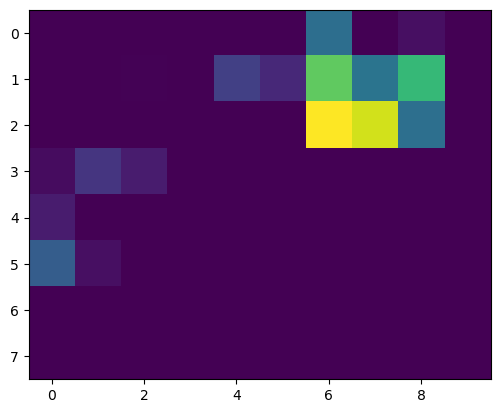

In [18]:
plt.imshow(tmp[0, :, :, 100])

In [19]:
class MultiTaskModel(nn.Module):
    def __init__(self, backbone, seg_head, depth_head):
        super().__init__()
        
        self.backbone = backbone
        self.seg_head = seg_head
        self.depth_head = depth_head
        
    def forward(self, x):
        x = self.backbone(x)
        seg_pred = self.seg_head(x)
        depth_pred = self.depth_head(x)

        return (seg_pred, depth_pred)

In [20]:
model = MultiTaskModel(resnet_backbone, seg_head, depth_head)

In [21]:
model.to(device)
seg_output, depth_output = model(image.to(device))

In [23]:
seg_output.shape, depth_output.shape

(torch.Size([16, 894, 8, 10]), torch.Size([16, 1, 8, 10]))

In [17]:
encoder.to(device)
outputs = encoder(image[0, :].unsqueeze(0).to(device))

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1, 1])

In [18]:
image[0, :].unsqueeze(0).shape

torch.Size([1, 3, 240, 320])